In [1]:
# import os

In [2]:
# train_dir = r'C:\Users\Student\Desktop\CV\kaggle_original_data'

In [4]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                include_top=False,
                input_shape=(150, 150, 3))


58892288/58889256 [==============================] - 6s 0us/step


In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# Extracting features using the pretrained convolutional base

In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [7]:
base_dir = r'C:\Users\Student\Desktop\CV\cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [8]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [9]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [10]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
train_features = np.reshape(train_features, (2000, 4*4* 512))
validation_features = np.reshape(validation_features, (1000, 4*4* 512))
test_features = np.reshape(test_features, (1000, 4*4* 512))

# Defining and training the densely connected classifier

In [12]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
            loss='binary_crossentropy',
            metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

C:\Users\Student\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
100/100 [==============================] - 13s 22ms/step - loss: 0.6988 - acc: 0.6165 - val_loss: 0.4189 - val_acc: 0.8450
Epoch 2/30
100/100 [==============================] - 2s 19ms/step - loss: 0.4351 - acc: 0.8053 - val_loss: 0.3454 - val_acc: 0.8700
Epoch 3/30
100/100 [==============================] - 2s 19ms/step - loss: 0.3571 - acc: 0.8403 - val_loss: 0.3094 - val_acc: 0.8870
Epoch 4/30
100/100 [==============================] - 2s 19ms/step - loss: 0.3177 - acc: 0.8662 - val_loss: 0.2936 - val_acc: 0.8890
Epoch 5/30
100/100 [==============================] - 2s 20ms/step - loss: 0.2994 - acc: 0.8824 - val_loss: 0.2881 - val_acc: 0.8830
Epoch 6/30
100/100 [==============================] - 2s 19ms/step - loss: 0.2758 - acc: 0.8880 - val_loss: 0.2716 - val_acc: 0.8920
Epoch 7/30
100/100 [==============================] - 2s 18ms/step - loss: 0.2289 - acc: 0.9075 - val_loss: 0.2587 - val_acc: 0.9000
Epoch 8/30
100/100 [==============================] - 2s 18ms/step -

# Plotting the results

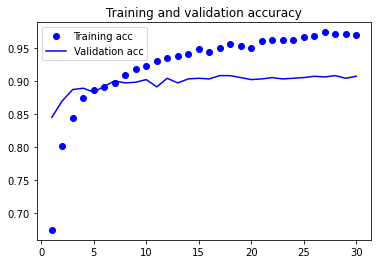

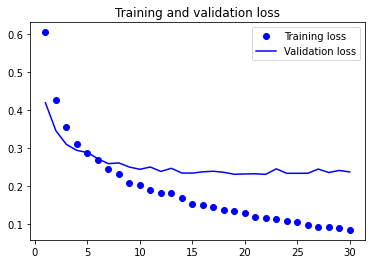

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()